<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2025_hands_on/blob/main/Week07_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

## Introduction

Transfer learning is a powerful technique in deep learning that leverages pretrained models (pretrained weights) to solve new tasks. By reusing learned features and weights, it reduces training time and data requirements. In this notebook, we explore transfer learning of one of popular CNN models called VGG16 pretrained with the ImageNet dataset.

### ImageNet dataset
The ImageNet dataset is one of the most famous datasets for image classification tasks. The dataset consists of more than 1.2 million images with 1,000 categories that were manually labeled by humans. It is often used for benchmarking the models' performance.

ImageNet Dataset https://www.image-net.org/update-mar-11-2021.php

PyTorch provides popular image classification models pretrained with the ImageNet dataset.

Models and Pretrained Weights https://docs.pytorch.org/vision/main/models.html

### GPU

We will use a GPU to train CNN models. Please make sure your runtime type is GPU (cuda).

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

In [ ]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_properties(0))

### General Packages

Let's import general Python packages.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

## Data Preparation

### CIFAR10

We will use the CIFAR10 dataset with the standardization and augmentation techniques. Data preparation process is almost same as last week. The values of means and stds of the ImageNet dataset `means = (0.485, 0.456, 0.406), stds = (0.229, 0.224, 0.225)` are used for the standardization because we will use the VGG16 pretrained with the ImageNet dataset.

In [ ]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2

# means and stds for ImageNet dataset
means = (0.485, 0.456, 0.406)
stds = (0.229, 0.224, 0.225)

classnames = {0:"plane",
              1:"car",
              2:"bird",
              3:"cat",
              4:"deer",
              5:"dog",
              6:"frog",
              7:"horse",
              8:"ship",
              9:"truck"}

train_dataset = CIFAR10(root="cifar10",
                        train=True,
                        download=True,
                        transform=v2.Compose([
                            v2.ToTensor(),               # convert to torch.tensor
                            v2.Normalize(means, stds),   # standardization
                            v2.Resize(128),

                            # data augmentation
                            v2.RandomHorizontalFlip(p=0.5),
                            # v2.RandomVerticalFlip(p=0.5),
                            v2.RandomRotation(degrees=10),
                            # v2.RandomPerspective(distortion_scale=0.3, p=0.5)
                            ])
                        )

test_dataset = CIFAR10(root="cifar10",
                        train=False,
                        download=True,
                        transform=v2.Compose([
                            v2.ToTensor(),                # convert to torch.tensor
                            v2.Normalize(means, stds),    # standardization
                            v2.Resize(128),
                            ])
                        )

### DataLoader

Then we create `DataLoader` objects for feeding data to the model. This is exactly same as we did with Iris dataset.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

That's it for data preparation!

## Model Building

### Transfer Learning (Re-train Pretrained Model)

#### Load Pretrained Model
The pretrained models can be downloaded using `torchvison.models`. We will use a model called VGG16 which is one of the well-known image classification models. By setting `models.vgg16(weights="IMAGENET1K_V1")`, we can load the VGG16 model pretrained with the dataset called ImageNet. ImageNet dataset consists of more than 1.2 million images with 1000 categories.

VGG16 Original Paper https://arxiv.org/abs/1409.1556

ImageNet Dataset https://www.image-net.org/update-mar-11-2021.php

In [ ]:
import torchvision.models as models

model = models.vgg16(weights="IMAGENET1K_V1")
print(model)

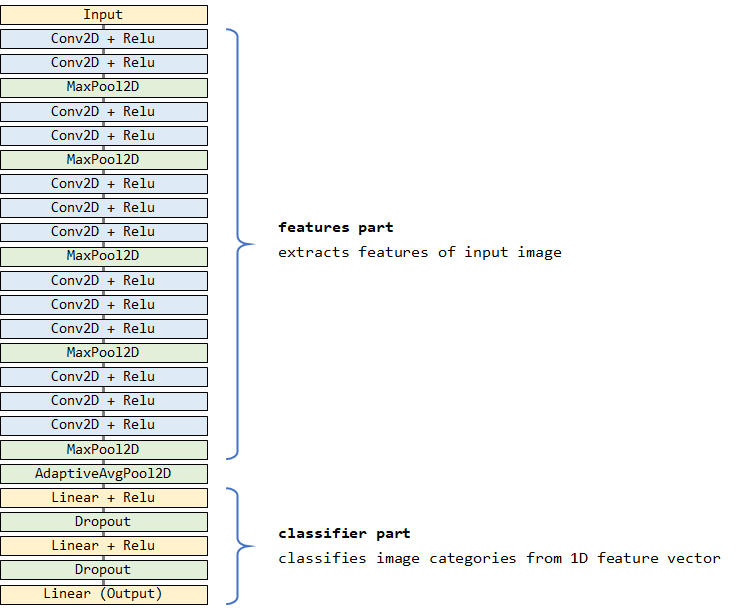

Note that the transfer learning is not allowed to be used in our Image Classification Competition. However, you can still use popular models like VGG and ResNet etc without loading pretrained weights. Then you can train them from scratch.

In [ ]:
vgg16 = models.vgg16(weights=None)
resnet50 = models.resnet50(weights=None)

#### Replace Output Layer
The number of output neurons of the pretrained VGG16 model is 1000. This is because this model is designed for classifying 1000 categories of images.

In [ ]:
model.classifier[6]

Since we are going to classify CIFAR10 dataset, the number of output neurons needs to be 10. Therefore we have to replace the last layer.

In [ ]:
import torch.nn as nn
model.classifier[6] = nn.Linear(4096, 10)   # replace the last layer
print(model)

In [ ]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

#### Freeze Parameters
The pretrained VGG16 model is well-trained with the ImageNet dataset, therefore the model parameters (weights and biases) are already good for general image classification tasks. In such case, it might be better to keep (freeze) most of the parameters in the model and re-train only a few layers of the model with the new dataset.

In order to do so, we make all of the parameters in the model to be frozen by setting `requires_grad=False`.

In [ ]:
for param in model.parameters():
    param.requires_grad = False

Then we set `requires_grad=Ture` to some specific layers so that they will be trained.

For example if we want to train only the parameters in the last layer (`model.classfier[6]`, 6th layer in the classifier part), we can do

In [ ]:
model.classifier[6].weight.requires_grad = True
model.classifier[6].bias.requires_grad = True

If we want to train other layers, we can do like

In [ ]:
# 0th layer in the classifier part
# model.classifier[0].weight.requires_grad = True
# model.classifier[0].bias.requires_grad = True

# 3rd layer in the classifier part
# model.classifier[3].weight.requires_grad = True
# model.classifier[3].bias.requires_grad = True

#### torchinfo
Let's see how the data shape changes in the model.

In [ ]:
for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

## Training

### Loss Function

We use the cross-entropy loss as the loss function since this is a classification task.

In [ ]:
loss_func = nn.CrossEntropyLoss()

### Optimizer

We use the Adam optimizer.

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### L1/L2 Regularization

We define the fuctions to calculate L1 and L2 norms.

In [ ]:
def get_l1_norm(model=model):
    l1_norm = 0
    for p in model.parameters():
        l1_norm += p.abs().sum()
    return l1_norm

print("L1 Norm Penalty:", get_l1_norm(model).item())

In [ ]:
def get_l2_norm(model=model):
    l2_norm = 0
    for p in model.parameters():
        l2_norm += p.pow(2).sum()
    return l2_norm

print("L2 Norm Penalty:", get_l2_norm(model).item())

### Training Loop

Now we can train the model.

In [ ]:
model = models.vgg16(weights="IMAGENET1K_V1")    # load pretrained model
# model = models.vgg16(weights=None)             # load model without pretrained weights
model.classifier[6] = nn.Linear(4096, 10)        # replace the last Linear layer

# freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# enable training for the specific layers
# model.classifier[0].weight.requires_grad = True
# model.classifier[0].bias.requires_grad = True
model.classifier[3].weight.requires_grad = True
model.classifier[3].bias.requires_grad = True
model.classifier[6].weight.requires_grad = True
model.classifier[6].bias.requires_grad = True

print(summary(model, input_shape))

model = model.to(device)                               # load model onto GPU
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-4)    # set optimizer
epochs = 10

best_model_path = 'best_model.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU

        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss

        #--- L1/L2 regularizaiton ---#
        # alpha = 0.001
        # loss = loss + alpha * get_l2_norm(model)    # add L2 penalty
        # loss = loss + alpha * get_l1_norm(model)    # add L1 penalty
        #----------------------------#

        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test")

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            #--- L1/L2 regularizaiton ---#
            # loss = loss + alpha * get_l2_norm(model)    # add L2 penalty
            # loss = loss + alpha * get_l1_norm(model)    # add L1 penalty
            #----------------------------#

            test_loss += loss.item()                                # add up loss value

            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count.item()/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), best_model_path)
        print(f"Test accuracy improved from {best_accuracy:.3f} to {test_accuracy:.3f}")
        print(f"Model saved at {best_model_path}")
        best_accuracy = test_accuracy

### Learning Curves

Let's visualize the accuracy and the loss curves for train and test data.

In [ ]:
plt.figure(figsize=(5,3))
plt.rcParams["font.size"]=10
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

In [ ]:
plt.figure(figsize=(5,3))
plt.rcParams["font.size"]=10
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Evaluation

### Load the Best Model

Now we can load the best model. What we saved in `best_model.pth` is only the model parameters. So first we need to load an initialized (not trained) model and then load the trained model parameters in there.

In [ ]:
model = models.vgg16(weights=None)            # load pretrained model
model.classifier[6] = nn.Linear(4096, 10)        # replace the last Linear layer

model = model.to(device)                           # load an initialized model
model.load_state_dict(torch.load(best_model_path))   # load model parameters to the initialized model

### Test Accuracy

We should check accuracy of the model for all of the test data.

In [ ]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode

    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

### Confusion Matrix

Then let's check the confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(10,6))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

### Predictions for Test Data

Let's see predictions for some test data.

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(50):
    image, _ = test_dataset[i]
    image = np.transpose(image, (1,2,0))

    # if data standardization was applied, uncomment following three lines
    image[:, :, 0] = image[:, :, 0]*stds[0]+means[0]
    image[:, :, 1] = image[:, :, 1]*stds[1]+means[1]
    image[:, :, 2] = image[:, :, 2]*stds[2]+means[2]

    plt.subplot(5, 10, i+1)
    plt.imshow(image)

    true_class = classnames[y_test_all[i]]
    pred_class = classnames[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")

## Conclusion
Now you can try to improve the test accuracy by changing trainable layers, training epochs, learning rates and so on. You can even try other pre-trained models.
